## Co-factor swap

#### Co-factors:

NAD+ / NADH: Nicotinamide adenine dinucleotide (NAD+) is reduced to NADH in the conversion of isoamyl aldehyde to isoamyl alcohol. This is an oxidation-reduction reaction where NAD+ acts as an oxidizing agent.

CoASH / Acetyl-CoA: Coenzyme A (CoASH) is used in the formation of acetyl-CoA, which is a substrate for the reaction that synthesizes isoamyl acetate. Acetyl-CoA is a key molecule in metabolic processes and is formed from acetate and CoASH with the input of energy from ATP.

ATP / AMP + PPi: Adenosine triphosphate (ATP) is converted to adenosine monophosphate (AMP) and inorganic pyrophosphate (PPi) in the reaction that activates acetate to acetyl adenylate as a precursor to acetyl-CoA formation.

In the code the following was done:
- Model yeast8 was loaded
- The objective was set to maximize the production of isoamyl acetate
- The theoretical yield was set to production of isoamyl acetate divided by the uptake of glucose
- The algorithm was run and the result was visualized

In [27]:
# fix the cameo import errors
from collections.abc import Mapping
import os
import pandas as pd
from cobra import Reaction, Metabolite
import matplotlib.pyplot as plt
from cameo.core import manipulation
from cameo import fba, flux_variability_analysis
from cobra.io import read_sbml_model
from cameo import load_model
from matplotlib import pyplot as plt
from cameo.flux_analysis.analysis import flux_variability_analysis as fva
from cameo.util import TimeMachine
from cobra.core.gene import GPR
from cameo.strain_design.heuristic.evolutionary.objective_functions import product_yield
from cameo.strain_design.heuristic.evolutionary_based import CofactorSwapOptimization

In [28]:
model = read_sbml_model("Models/yeast8.xml")

In [29]:
# Choose the reaction that produces isoamyl acetate as the objective (r_1180 transports the product to the extracellular medium).
objective_reaction = model.reactions.r_1180
model.objective = objective_reaction
print(f'Objective set to maximize {objective_reaction.id}: {objective_reaction.reaction}')

Objective set to maximize r_1180: s_0927 --> s_0928


Reactions regarding isoamyl acetate:

r_0160(alcohol acetyltransferase (isoamyl alcohol)):  s_0373 (acetyl-CoA) + s_0929 (isoamyl alcohol) --> s_0529 (CoA) + s_0927 (isoamyl acetate)

r_0180 (aldehyde dehydrogenase (isoamyl alcohol, NAD)): s_0236(3-methyilbutanal) + s_0799 (glyoxylate)+ s_1205 (NADH) --> s_0931 (isoamylol) + s_1200 (NAD)

r_0656 (isoamyl acetate-hydrolyzing esterase): eliminates isoamyl acetate

r_1180 --> Transports isoamyl acetate to the outside 


Now use NADP and NADH instead of NAD and NADH. The reaction occurs in the m compartment


In [30]:
# Setting the progesterone yield as the formation of progesterone divided by the optake of glucose
py = product_yield(model.reactions.r_1180, model.exchanges.r_1714)
py

In [31]:
# Running the CofactorSwapOptimization Algorithm
# Find reactions that all have the targeted co-factor pairs and add reactions that have the co-factors swapped.
swap = CofactorSwapOptimization(model=model, plot=False, cofactor_id_swaps=(["s_1198","s_1203"],["s_0434","s_0423"]),objective_function=py)
print(f'Co-factor swap optimization of the model {model.id} used to increase available {swap._metadata["swap_pairs"][0][0]} and {swap._metadata["swap_pairs"][0][1]} on the cost of {swap._metadata["swap_pairs"][1][0]} and {swap._metadata["swap_pairs"][1][1]}')
cofactor_swap_targets = swap.run(max_size = 10)

Co-factor swap optimization of the model yeastGEM_v8__46__7__46__1 used to increase available s_1198 and s_1203 on the cost of s_0434 and s_0423
Starting optimization at Sun, 19 Nov 2023 22:03:06


HBox()

Finished after 00:03:24


In [32]:
cofactor_swap_targets

,index,targets,fitness
0,0,"(r_0714,)",0.777778
1,1,"(r_0472,)",0.777778
2,3,"(r_4584,)",0.777778
3,5,"(r_0211,)",0.777778
4,6,"(r_0491,)",0.777778
5,8,"(r_0916,)",0.777778
6,20,"(r_0142,)",0.777778
7,23,"(r_2115,)",0.777778
8,27,"(r_0770, r_0514)",0.777778
9,30,"(r_1116,)",0.777778


In [69]:
# Stats of the GAPD reaction
print(model.reactions.r_0714)
print(model.reactions.r_0471)
print(model.reactions.r_4585)
print(model.reactions.r_0211)
print(model.reactions.r_0491)
print(model.reactions.r_0916)
print(model.reactions.r_0142)
print(model.reactions.r_2115)
print(model.reactions.r_0770)
print(model.reactions.r_1116)
print(model.reactions.r_0208)

r_0714: s_0066 + s_1198 <=> s_0794 + s_1203 + s_1271
r_0471: s_0180 + s_0419 + s_0794 + s_1212 --> s_0803 + s_0991 + s_1207
r_4585: s_0803 + s_4192 --> s_0558 + s_4193
r_0211: s_0434 + s_0803 + s_0973 + s_0999 --> s_0423 + s_0633 + s_0794 + s_0969 + s_0991
r_0491: s_0629 + s_0794 + s_1203 --> s_0767 + s_1198
r_0916: s_0434 + s_1408 --> s_0423 + s_0794 + s_1386
r_0142: s_0386 + s_0434 --> s_0394 + s_0423 + s_0794
r_2115: s_0359 + s_0794 + s_1203 --> s_0680 + s_1198
r_0770: s_0794 + s_1203 + s_1537 --> s_1198 + s_1535
r_1116: s_0426 + s_0434 + s_0801 --> s_0423 + s_0439 + s_0794
r_0208: s_0434 + s_0973 + s_0979 <=> s_0015 + s_0423 + s_0633 + s_0794


In [120]:
model.reactions.r_0714

Reaction identifier,r_0714
Name,"malate dehydrogenase, cytoplasmic"
Memory address,0x16ff5c24350
Stoichiometry,s_0066 + s_1198 <=> s_0794 + s_1203 + s_1271 (S)-malate + NAD <=> H+ + NADH + oxaloacetate
GPR,YOL126C
Lower bound,-1000.0
Upper bound,1000.0


In [103]:
compartment = model.reactions.get_by_id('r_0491').compartments
print(compartment)
model.reactions.r_0491

{'c'}


Reaction identifier,r_0491
Name,glycerol-3-phosphate dehydrogenase (NAD)
Memory address,0x16ff5a912d0
Stoichiometry,s_0629 + s_0794 + s_1203 --> s_0767 + s_1198 dihydroxyacetone phosphate + H+ + NADH --> glycerol 3-phosphate + NAD
GPR,YDL022W or YOL059W
Lower bound,0.0
Upper bound,1000.0


In [105]:
compartment = model.reactions.get_by_id('r_2115').compartments
print(compartment)
model.reactions.r_2115

{'c'}


Reaction identifier,r_2115
Name,"alcohol dehydrogenase, (acetaldehyde to ethanol)"
Memory address,0x16ff00f4390
Stoichiometry,s_0359 + s_0794 + s_1203 --> s_0680 + s_1198 acetaldehyde + H+ + NADH --> ethanol + NAD
GPR,YBR145W or YOL086C
Lower bound,0.0
Upper bound,1000.0


In [106]:
compartment = model.reactions.get_by_id('r_0770').compartments
print(compartment)
model.reactions.r_0770


{'c', 'm'}


Reaction identifier,r_0770
Name,"NADH dehydrogenase, cytosolic/mitochondrial"
Memory address,0x16ff5c5e990
Stoichiometry,s_0794 + s_1203 + s_1537 --> s_1198 + s_1535 H+ + NADH + ubiquinone-6 --> NAD + ubiquinol-6
GPR,YDL085W or YMR145C
Lower bound,0.0
Upper bound,1000.0


In [83]:
# Knock out of GAPD genes
KOs = ["YOL126C", "YDL022W", "YOL059W", "YBR145W", "YOL086C", "YDL085W", "YMR145C" ]
model_coswap1 = model.copy()
model_coswap1.id = "yeast8_coswap1"
print(f"Model {model_coswap1.id} were made as a copy of {model.id}")
for KO in KOs:
    model_coswap1.genes.get_by_id(KO).knock_out()
    

# if model_coswap1.genes.get_by_id("YLR174W").functional == False:
#     print(f"{model_coswap1.genes.get_by_id("YLR174W").name} were knocked out")

Model yeast8_coswap1 were made as a copy of yeastGEM_v8__46__7__46__1


In [84]:
infilename = "Models/yeast8.xml"

In [125]:
# Adding NADP dependent GAPD reaction
def import_reactions(reaction_dict,infilename):
    for m, reactions in reaction_dict.items():
        print(f"For model {m.id}:")
        with open(infilename,"r") as infile:
            infile.readline()
            for line in infile:
                line = line.rstrip().split(",")
                if line[0] in reactions:
                    r = Reaction(line[0])
                    r.name = line[2]
                    if line[3] != "":
                        r.subsystem = line[3]
                    r.lower_bound = float(line[4])
                    r.upper_bound = float(line[5])
                    if line[1] != "":
                        r.gpr = GPR.from_string(line[1])
                    for i in range(int(len(line[6:])/2)):
                        metaboliteID = line[6+i*2]
                        if metaboliteID != "":
                            metaboliteID = m.metabolites.get_by_id(metaboliteID)
                            bin = float(line[7+i*2])
                            r.add_metabolites({metaboliteID:bin})
                    print(f'Adding reaction {r} | enzyme: {r.gpr}')
                    m.add_reactions([r])


reaction_dict = {model_coswap1:("R0714")}
import_reactions(reaction_dict,"Files/co-factor_swap_reactions.csv")
reaction_dict2 = {model_coswap1:("R0491")}
import_reactions(reaction_dict2,"Files/co-factor_swap_reactions2.csv")
reaction_dict3 = {model_coswap1:("R2115")}
import_reactions(reaction_dict3,"Files/co-factor_swap_reactions3.csv")
reaction_dict4 = {model_coswap1:("R0770")}
import_reactions(reaction_dict4,"Files/co-factor_swap_reactions4.csv")


Ignoring reaction 'R0714' since it already exists.


Ignoring reaction 'R0491' since it already exists.
Ignoring reaction 'R2115' since it already exists.
Ignoring reaction 'R0770' since it already exists.


For model yeast8_coswap1:
Adding reaction R0714: s_0066 + s_0434 <=> s_0423 + s_0794 + s_1271 | enzyme: malate_dehydrogenase
For model yeast8_coswap1:
Adding reaction R0491: s_0423 + s_0629 + s_0794 --> s_0434 + s_0767 | enzyme: glycerol-3-phosphate_dehydrogenase
For model yeast8_coswap1:
Adding reaction R2115: s_0359 + s_0423 + s_0794 --> s_0434 + s_0680 | enzyme: alcohol_dehydrogenase
For model yeast8_coswap1:
Adding reaction R0770: s_0423 + s_0794 + s_1537 --> s_0434 + s_1535 | enzyme: NADH_dehydrogenase


In [100]:
# Calculate maximum growth
models = [model,model_coswap1]
biomass = []
for i, m in enumerate(models):
    with m:
        objective_reaction = m.reactions.r_2111
        m.objective = objective_reaction
        biomass.append(m.optimize().objective_value)
    print(f'{m.id} | Maximum growth: {round(biomass[i],3)} mmol/gDW*h')

# Calculate procentage increase in µ
print(f"Procentage increase in maximum growth: {round((biomass[1]/biomass[0]-1)*100,10)}%")

yeastGEM_v8__46__7__46__1 | Maximum growth: 0.082 mmol/gDW*h
yeast8_coswap1 | Maximum growth: 0.139 mmol/gDW*h
Procentage increase in maximum growth: 69.8981963965%


In [101]:
ia = []
for i, m in enumerate(models):
    with m:
        objective_reaction = m.reactions.r_1180
        m.objective = objective_reaction
        ia.append(m.optimize().objective_value)
    print(f'{m.id} | Maximum isoamyl acetate productivity: {round(pp[i],3)} mmol/gDW*h')

    # Calculate procentage increase 
print(f"Procentage increase in maximum isoamyl acetate production: {round((ia[1]/ia[0]-1)*100,10)}%")

yeastGEM_v8__46__7__46__1 | Maximum isoamyl acetate productivity: 0.556 mmol/gDW*h
yeast8_coswap1 | Maximum isoamyl acetate productivity: 0.667 mmol/gDW*h
Procentage increase in maximum isoamyl acetate production: 19.8171374695%


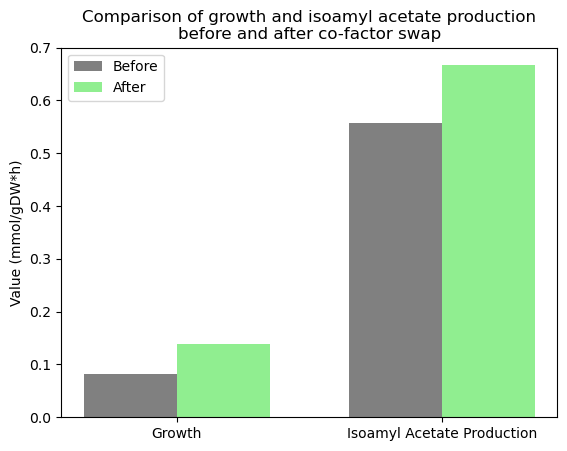

In [140]:
import matplotlib.pyplot as plt

# Assuming you have the following data from the output:
growth_before = biomass[0]  # mmol/gDW*h
growth_after = biomass[1]  # mmol/gDW*h
ia_before = ia[0]  # mmol/gDW*h
ia_after = ia[1]  # mmol/gDW*h

# Calculate percentage increase
growth_increase = ((growth_after - growth_before) / growth_before) * 100
ia_increase = ((ia_after - ia_before) / ia_before) * 100

# Data for plotting
categories = ['Growth', 'Isoamyl Acetate Production']
before = [growth_before, ia_before]
after = [growth_after, ia_after]

# Creating the bar plot
fig, ax = plt.subplots()

# Set position of bar on X axis
bar_width = 0.35
r1 = range(len(before))
r2 = [x + bar_width for x in r1]

# Make the plot
ax.bar(r1, before, color='grey', width=bar_width, label='Before')
ax.bar(r2, after, color='lightgreen', width=bar_width,  label='After')

# Add labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Value (mmol/gDW*h)')
ax.set_title('Comparison of growth and isoamyl acetate production\nbefore and after co-factor swap')
ax.set_xticks([r + bar_width/2 for r in range(len(before))])
ax.set_xticklabels(categories)
ax.legend()

# Display the bar plot
plt.show()
